In [1]:
%pip install transformers sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=2dea48d6aa3b5c7440e1a8a98d1f366cedb949d6120858ee89b6a1b3bd4062a4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
from sentence_transformers import SentenceTransformer, models
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import datetime
import random
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
from google.colab import files
uploaded = files.upload()

Saving mohler_dataset.csv to mohler_dataset.csv


In [36]:
# Load your dataset into a Pandas DataFrame
df = pd.read_csv('mohler_dataset.csv')
# df = pd.read_csv('dataset.csv')

In [37]:
df[:5]

,id,question,desired_answer,student_answer,score_me,score_other,score_avg
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0


In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [11]:
# Instantiate the BERT tokenizer
# You can use larger variants of the model, here we're using the base model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
class BDataset():
    def __init__(self, dataset):
        # Normalize the similarity scores in the dataset
        similarity_scores = dataset['score_avg']
        self.normalized_similarity_scores = [i/5.0 for i in similarity_scores]
        self.first_sentences = dataset['desired_answer']
        self.second_sentences = dataset['student_answer']
        self.concatenated_sentences = [[str(x), str(y)] for x,y in zip(self.first_sentences, self.second_sentences)]

    def __len__(self):
        return len(self.concatenated_sentences)

    def get_batch_labels(self, idx):
        return torch.tensor(self.normalized_similarity_scores[idx])

    def get_batch_texts(self, idx):
        return tokenizer(self.concatenated_sentences[idx], padding='max_length', max_length=128, truncation=True, return_tensors="pt")

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


def collate_fn(texts):
    input_ids = texts['input_ids']
    attention_masks = texts['attention_mask']
    features = [{'input_ids': input_id, 'attention_mask': attention_mask}
                for input_id, attention_mask in zip(input_ids, attention_masks)]
    return features

In [46]:
len(df)

2273

In [38]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [40]:
train_ds = BDataset(df)

In [45]:
train_ds = BDataset(train_df)
val_ds = BDataset(val_df)

train_size = len(train_ds)
val_size = len(val_ds)

print('Training samples : {} '.format(train_size))
print('Validation samples : {} '.format(val_size))

Training samples : 1636 
Validation samples : 182 


In [47]:
class Bert(torch.nn.Module):
    def __init__(self):
        super(Bert, self).__init__()
        self.bert = models.Transformer('bert-base-uncased', max_seq_length=128)
        self.pooling_layer = models.Pooling(self.bert.get_word_embedding_dimension())
        self.sts_bert = SentenceTransformer(modules=[self.bert, self.pooling_layer])

    def forward(self, input_data):
        output = self.sts_bert(input_data)['sentence_embedding']
        return output

In [48]:
# Instantiate the model and move it to GPU
model = Bert()
model.to(device)

Bert(
  (bert): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (pooling_layer): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (sts_bert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
)

In [49]:
class CosineSimilarityLoss(torch.nn.Module):
    def __init__(self,  loss_fn=torch.nn.MSELoss(), transform_fn=torch.nn.Identity()):
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fn = loss_fn
        self.transform_fn = transform_fn
        self.cos_similarity = torch.nn.CosineSimilarity(dim=1)

    def forward(self, inputs, labels):
        emb_1 = torch.stack([inp[0] for inp in inputs])
        emb_2 = torch.stack([inp[1] for inp in inputs])
        outputs = self.transform_fn(self.cos_similarity(emb_1, emb_2))
        return self.loss_fn(outputs, labels.squeeze())

In [50]:
batch_size = 8
train_dataloader = DataLoader(
            train_ds,  # The training samples.
            num_workers = 4,
            batch_size = batch_size, # Use this batch size.
            shuffle=True # Select samples randomly for each batch
        )

validation_dataloader = DataLoader(
            val_ds,
            num_workers = 4,
            batch_size = batch_size # Use the same batch size
        )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-6)

In [51]:
# total number of epochs
epochs = 100

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [29]:
def train():
  seed_val = 42
  criterion = CosineSimilarityLoss()
  criterion = criterion.to(device)

  random.seed(seed_val)
  torch.manual_seed(seed_val)

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []

  for epoch_i in range(0, epochs):

      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      total_train_loss = 0

      model.train()

      # For each batch of training data...
      for train_data, train_label in tqdm(train_dataloader):

          train_data['input_ids'] = train_data['input_ids'].to(device)
          train_data['attention_mask'] = train_data['attention_mask'].to(device)

          train_data = collate_fn(train_data)
          model.zero_grad()

          output = [model(feature) for feature in train_data]

          loss = criterion(output, train_label.to(device))
          total_train_loss += loss.item()

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()


      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      print("Average training loss: {0:.5f}".format(avg_train_loss))
      print("Running Validation...")

      model.eval()

      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for val_data, val_label in tqdm(validation_dataloader):

          val_data['input_ids'] = val_data['input_ids'].to(device)
          val_data['attention_mask'] = val_data['attention_mask'].to(device)

          val_data = collate_fn(val_data)

          with torch.no_grad():
              output = [model(feature) for feature in val_data]

          loss = criterion(output, val_label.to(device))
          total_eval_loss += loss.item()

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      print("Validation Loss: {0:.5f}".format(avg_val_loss))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'train_loss': avg_train_loss,
              'valid_loss': avg_val_loss,
          }
      )

  print("Training complete!")

  return model, training_stats

In [30]:
# Launch the training
model, training_stats = train()

======== Epoch 1 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Average training loss: 0.06224
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Validation Loss: 0.05217
======== Epoch 2 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Average training loss: 0.03895
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Validation Loss: 0.05231
======== Epoch 3 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.05060
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Validation Loss: 0.05243
======== Epoch 4 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


Average training loss: 0.05699
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Validation Loss: 0.05265
======== Epoch 5 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Average training loss: 0.06177
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Validation Loss: 0.05285
======== Epoch 6 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Average training loss: 0.04630
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Validation Loss: 0.05302
======== Epoch 7 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Average training loss: 0.04367
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Validation Loss: 0.05328
======== Epoch 8 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Average training loss: 0.04674
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Validation Loss: 0.05353
======== Epoch 9 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Average training loss: 0.03286
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05362
======== Epoch 10 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Average training loss: 0.05660
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.05366
======== Epoch 11 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Average training loss: 0.03538
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Validation Loss: 0.05364
======== Epoch 12 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Average training loss: 0.04822
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Validation Loss: 0.05361
======== Epoch 13 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Average training loss: 0.03008
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Validation Loss: 0.05355
======== Epoch 14 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Average training loss: 0.02563
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Validation Loss: 0.05350
======== Epoch 15 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Average training loss: 0.03282
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Validation Loss: 0.05348
======== Epoch 16 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Average training loss: 0.02269
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Validation Loss: 0.05349
======== Epoch 17 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Average training loss: 0.03600
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Validation Loss: 0.05346
======== Epoch 18 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Average training loss: 0.02167
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Validation Loss: 0.05340
======== Epoch 19 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Average training loss: 0.02932
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Validation Loss: 0.05341
======== Epoch 20 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Average training loss: 0.03074
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Validation Loss: 0.05352
======== Epoch 21 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Average training loss: 0.03711
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Validation Loss: 0.05372
======== Epoch 22 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Average training loss: 0.03920
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Validation Loss: 0.05392
======== Epoch 23 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Average training loss: 0.02761
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Validation Loss: 0.05410
======== Epoch 24 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Average training loss: 0.03356
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Validation Loss: 0.05433
======== Epoch 25 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Average training loss: 0.03204
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Validation Loss: 0.05451
======== Epoch 26 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Average training loss: 0.03217
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Validation Loss: 0.05463
======== Epoch 27 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Average training loss: 0.03349
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Validation Loss: 0.05475
======== Epoch 28 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.03201
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Validation Loss: 0.05491
======== Epoch 29 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.01733
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Validation Loss: 0.05504
======== Epoch 30 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Average training loss: 0.02562
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Validation Loss: 0.05513
======== Epoch 31 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Average training loss: 0.01759
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Validation Loss: 0.05523
======== Epoch 32 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.03569
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Validation Loss: 0.05530
======== Epoch 33 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.02131
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Validation Loss: 0.05534
======== Epoch 34 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Average training loss: 0.01615
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Validation Loss: 0.05532
======== Epoch 35 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Average training loss: 0.03126
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Validation Loss: 0.05533
======== Epoch 36 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Average training loss: 0.02146
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Validation Loss: 0.05544
======== Epoch 37 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Average training loss: 0.02219
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Validation Loss: 0.05560
======== Epoch 38 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Average training loss: 0.02799
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Validation Loss: 0.05580
======== Epoch 39 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Average training loss: 0.01808
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Validation Loss: 0.05601
======== Epoch 40 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Average training loss: 0.02552
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Validation Loss: 0.05617
======== Epoch 41 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Average training loss: 0.02286
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Validation Loss: 0.05637
======== Epoch 42 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.02390
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Validation Loss: 0.05656
======== Epoch 43 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Average training loss: 0.01814
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05669
======== Epoch 44 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


Average training loss: 0.01845
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Validation Loss: 0.05680
======== Epoch 45 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Average training loss: 0.01872
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Validation Loss: 0.05685
======== Epoch 46 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Average training loss: 0.01573
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Validation Loss: 0.05685
======== Epoch 47 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Average training loss: 0.03087
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Validation Loss: 0.05685
======== Epoch 48 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Average training loss: 0.01442
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05687
======== Epoch 49 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Average training loss: 0.01436
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.05689
======== Epoch 50 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.01010
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Validation Loss: 0.05693
======== Epoch 51 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Average training loss: 0.01691
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.05699
======== Epoch 52 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.01152
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Validation Loss: 0.05705
======== Epoch 53 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.02089
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Validation Loss: 0.05710
======== Epoch 54 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Average training loss: 0.01104
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Validation Loss: 0.05710
======== Epoch 55 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.01431
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Validation Loss: 0.05707
======== Epoch 56 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Average training loss: 0.01351
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Validation Loss: 0.05704
======== Epoch 57 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Average training loss: 0.00898
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Validation Loss: 0.05699
======== Epoch 58 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Average training loss: 0.01205
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Validation Loss: 0.05695
======== Epoch 59 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Average training loss: 0.01521
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05695
======== Epoch 60 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.01410
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Validation Loss: 0.05699
======== Epoch 61 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.00899
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Validation Loss: 0.05702
======== Epoch 62 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Average training loss: 0.01977
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Validation Loss: 0.05707
======== Epoch 63 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Average training loss: 0.01985
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Validation Loss: 0.05712
======== Epoch 64 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Average training loss: 0.01380
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Validation Loss: 0.05716
======== Epoch 65 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Average training loss: 0.00991
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Validation Loss: 0.05717
======== Epoch 66 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Average training loss: 0.01770
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Validation Loss: 0.05719
======== Epoch 67 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Average training loss: 0.01270
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Validation Loss: 0.05722
======== Epoch 68 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Average training loss: 0.01204
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Validation Loss: 0.05726
======== Epoch 69 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Average training loss: 0.01477
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Validation Loss: 0.05732
======== Epoch 70 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.01374
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Validation Loss: 0.05737
======== Epoch 71 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Average training loss: 0.01441
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Validation Loss: 0.05739
======== Epoch 72 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00844
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Validation Loss: 0.05742
======== Epoch 73 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00983
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Validation Loss: 0.05741
======== Epoch 74 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.01983
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Validation Loss: 0.05740
======== Epoch 75 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.01270
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Validation Loss: 0.05743
======== Epoch 76 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


Average training loss: 0.01539
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Validation Loss: 0.05745
======== Epoch 77 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.01557
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Validation Loss: 0.05749
======== Epoch 78 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Average training loss: 0.01017
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Validation Loss: 0.05757
======== Epoch 79 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Average training loss: 0.01709
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Validation Loss: 0.05764
======== Epoch 80 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Average training loss: 0.01217
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Validation Loss: 0.05768
======== Epoch 81 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.01147
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Validation Loss: 0.05774
======== Epoch 82 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.01098
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Validation Loss: 0.05785
======== Epoch 83 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.01313
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Validation Loss: 0.05792
======== Epoch 84 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Average training loss: 0.00943
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Validation Loss: 0.05800
======== Epoch 85 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.00506
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Validation Loss: 0.05811
======== Epoch 86 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.00814
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Validation Loss: 0.05818
======== Epoch 87 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00933
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Validation Loss: 0.05823
======== Epoch 88 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Average training loss: 0.01231
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Validation Loss: 0.05830
======== Epoch 89 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Average training loss: 0.01006
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Validation Loss: 0.05840
======== Epoch 90 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Average training loss: 0.01485
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Validation Loss: 0.05850
======== Epoch 91 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Average training loss: 0.01125
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Validation Loss: 0.05863
======== Epoch 92 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00661
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Validation Loss: 0.05876
======== Epoch 93 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.00987
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Validation Loss: 0.05888
======== Epoch 94 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.00596
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Validation Loss: 0.05896
======== Epoch 95 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.01053
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Validation Loss: 0.05900
======== Epoch 96 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00945
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Validation Loss: 0.05903
======== Epoch 97 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Average training loss: 0.01186
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Validation Loss: 0.05905
======== Epoch 98 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.01239
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Validation Loss: 0.05905
======== Epoch 99 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Average training loss: 0.00964
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05904
======== Epoch 100 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Average training loss: 0.00774
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Validation Loss: 0.05905
======== Epoch 101 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Average training loss: 0.00600
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Validation Loss: 0.05904
======== Epoch 102 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Average training loss: 0.00941
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Validation Loss: 0.05902
======== Epoch 103 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.00540
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Validation Loss: 0.05901
======== Epoch 104 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.00711
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Validation Loss: 0.05899
======== Epoch 105 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.00513
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Validation Loss: 0.05899
======== Epoch 106 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00657
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Validation Loss: 0.05899
======== Epoch 107 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.00850
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Validation Loss: 0.05899
======== Epoch 108 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.00917
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Validation Loss: 0.05899
======== Epoch 109 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.00654
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Validation Loss: 0.05901
======== Epoch 110 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.01029
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Validation Loss: 0.05905
======== Epoch 111 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Average training loss: 0.00771
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Validation Loss: 0.05909
======== Epoch 112 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Average training loss: 0.00610
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Validation Loss: 0.05913
======== Epoch 113 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Average training loss: 0.00598
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Validation Loss: 0.05917
======== Epoch 114 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Average training loss: 0.00611
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Validation Loss: 0.05920
======== Epoch 115 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.00570
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05922
======== Epoch 116 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Average training loss: 0.00487
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Validation Loss: 0.05925
======== Epoch 117 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.00716
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Validation Loss: 0.05929
======== Epoch 118 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00545
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Validation Loss: 0.05931
======== Epoch 119 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Average training loss: 0.00491
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Validation Loss: 0.05931
======== Epoch 120 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.00816
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Validation Loss: 0.05931
======== Epoch 121 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Average training loss: 0.00463
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.05929
======== Epoch 122 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Average training loss: 0.00740
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Validation Loss: 0.05923
======== Epoch 123 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Average training loss: 0.01004
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Validation Loss: 0.05920
======== Epoch 124 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Average training loss: 0.00940
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Validation Loss: 0.05917
======== Epoch 125 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.00520
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Validation Loss: 0.05915
======== Epoch 126 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.00792
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Validation Loss: 0.05916
======== Epoch 127 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.00702
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05917
======== Epoch 128 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.00680
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Validation Loss: 0.05919
======== Epoch 129 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.00483
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05921
======== Epoch 130 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00936
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Validation Loss: 0.05924
======== Epoch 131 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00548
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.05929
======== Epoch 132 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00562
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Validation Loss: 0.05934
======== Epoch 133 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Average training loss: 0.00603
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Validation Loss: 0.05937
======== Epoch 134 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Average training loss: 0.00527
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation Loss: 0.05939
======== Epoch 135 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Average training loss: 0.00522
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.05941
======== Epoch 136 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Average training loss: 0.00693
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Validation Loss: 0.05942
======== Epoch 137 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00445
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Validation Loss: 0.05943
======== Epoch 138 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.00639
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Validation Loss: 0.05944
======== Epoch 139 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Average training loss: 0.00540
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Validation Loss: 0.05944
======== Epoch 140 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.00489
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Validation Loss: 0.05943
======== Epoch 141 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.00636
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Validation Loss: 0.05943
======== Epoch 142 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.00412
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Validation Loss: 0.05944
======== Epoch 143 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Average training loss: 0.00571
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Validation Loss: 0.05944
======== Epoch 144 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Average training loss: 0.00655
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Validation Loss: 0.05945
======== Epoch 145 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Average training loss: 0.00805
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Validation Loss: 0.05948
======== Epoch 146 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Average training loss: 0.00629
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Validation Loss: 0.05953
======== Epoch 147 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00698
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Validation Loss: 0.05957
======== Epoch 148 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.00409
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Validation Loss: 0.05960
======== Epoch 149 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Average training loss: 0.00755
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Validation Loss: 0.05963
======== Epoch 150 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00748
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Validation Loss: 0.05965
======== Epoch 151 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Average training loss: 0.00378
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Validation Loss: 0.05966
======== Epoch 152 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00397
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Validation Loss: 0.05967
======== Epoch 153 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.00516
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Validation Loss: 0.05969
======== Epoch 154 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Average training loss: 0.00380
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Validation Loss: 0.05973
======== Epoch 155 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Average training loss: 0.00439
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Validation Loss: 0.05976
======== Epoch 156 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Average training loss: 0.00447
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Validation Loss: 0.05979
======== Epoch 157 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


Average training loss: 0.00667
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Validation Loss: 0.05982
======== Epoch 158 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Average training loss: 0.00560
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Validation Loss: 0.05986
======== Epoch 159 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.00473
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.05988
======== Epoch 160 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


Average training loss: 0.00954
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Validation Loss: 0.05990
======== Epoch 161 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


Average training loss: 0.00811
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Validation Loss: 0.05993
======== Epoch 162 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Average training loss: 0.00704
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Validation Loss: 0.05995
======== Epoch 163 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Average training loss: 0.00775
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Validation Loss: 0.05997
======== Epoch 164 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Average training loss: 0.00584
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Validation Loss: 0.05999
======== Epoch 165 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Average training loss: 0.00632
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Validation Loss: 0.06000
======== Epoch 166 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Average training loss: 0.00458
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Validation Loss: 0.06002
======== Epoch 167 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Average training loss: 0.00311
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.06002
======== Epoch 168 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


Average training loss: 0.00452
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.06003
======== Epoch 169 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00325
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Validation Loss: 0.06004
======== Epoch 170 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Average training loss: 0.00654
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.06004
======== Epoch 171 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.00666
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Validation Loss: 0.06006
======== Epoch 172 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Average training loss: 0.00672
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Validation Loss: 0.06007
======== Epoch 173 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.00500
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Validation Loss: 0.06008
======== Epoch 174 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


Average training loss: 0.00360
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Validation Loss: 0.06008
======== Epoch 175 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.00491
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Validation Loss: 0.06007
======== Epoch 176 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Average training loss: 0.00605
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Validation Loss: 0.06007
======== Epoch 177 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Average training loss: 0.00356
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Validation Loss: 0.06006
======== Epoch 178 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Average training loss: 0.00539
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Validation Loss: 0.06006
======== Epoch 179 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00677
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Validation Loss: 0.06005
======== Epoch 180 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Average training loss: 0.00492
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Validation Loss: 0.06005
======== Epoch 181 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.00409
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Validation Loss: 0.06006
======== Epoch 182 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Average training loss: 0.00479
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Validation Loss: 0.06006
======== Epoch 183 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Average training loss: 0.00436
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.06007
======== Epoch 184 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00378
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Validation Loss: 0.06007
======== Epoch 185 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Average training loss: 0.00507
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.06007
======== Epoch 186 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Average training loss: 0.00570
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Validation Loss: 0.06008
======== Epoch 187 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Average training loss: 0.00593
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Validation Loss: 0.06008
======== Epoch 188 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Average training loss: 0.00450
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Validation Loss: 0.06009
======== Epoch 189 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Average training loss: 0.00641
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Validation Loss: 0.06009
======== Epoch 190 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Average training loss: 0.00500
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Validation Loss: 0.06009
======== Epoch 191 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Average training loss: 0.00335
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Validation Loss: 0.06009
======== Epoch 192 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Average training loss: 0.00415
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Validation Loss: 0.06009
======== Epoch 193 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Average training loss: 0.00544
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Validation Loss: 0.06009
======== Epoch 194 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Average training loss: 0.00330
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Validation Loss: 0.06009
======== Epoch 195 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00306
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Validation Loss: 0.06009
======== Epoch 196 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Average training loss: 0.00346
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Validation Loss: 0.06009
======== Epoch 197 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Average training loss: 0.00565
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Validation Loss: 0.06009
======== Epoch 198 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Average training loss: 0.00360
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Validation Loss: 0.06009
======== Epoch 199 / 200 ========
Training...


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Average training loss: 0.00654
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Validation Loss: 0.06009
======== Epoch 200 / 200 ========
Training...


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Average training loss: 0.00376
Running Validation...


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

Validation Loss: 0.06009
Training complete!


In [34]:
training_stats

[{'epoch': 1,
  'train_loss': 0.06224045902490616,
  'valid_loss': 0.052172768861055374},
 {'epoch': 2,
  'train_loss': 0.03894537687301636,
  'valid_loss': 0.052306003868579865},
 {'epoch': 3,
  'train_loss': 0.05059681460261345,
  'valid_loss': 0.052434056997299194},
 {'epoch': 4,
  'train_loss': 0.05698549561202526,
  'valid_loss': 0.0526498407125473},
 {'epoch': 5,
  'train_loss': 0.06176658719778061,
  'valid_loss': 0.05285392701625824},
 {'epoch': 6,
  'train_loss': 0.04630063287913799,
  'valid_loss': 0.05301505699753761},
 {'epoch': 7,
  'train_loss': 0.0436662957072258,
  'valid_loss': 0.053281933069229126},
 {'epoch': 8,
  'train_loss': 0.04673873074352741,
  'valid_loss': 0.05353342369198799},
 {'epoch': 9,
  'train_loss': 0.03286355268210173,
  'valid_loss': 0.05361923575401306},
 {'epoch': 10,
  'train_loss': 0.05660043656826019,
  'valid_loss': 0.053663626313209534},
 {'epoch': 11,
  'train_loss': 0.035380296409130096,
  'valid_loss': 0.05364181101322174},
 {'epoch': 12,


In [31]:
train_loss = []
valid_loss = []
for i in range(len(training_stats)):
    train_loss.append(training_stats[i]['train_loss'])
    valid_loss.append(training_stats[i]['valid_loss'])

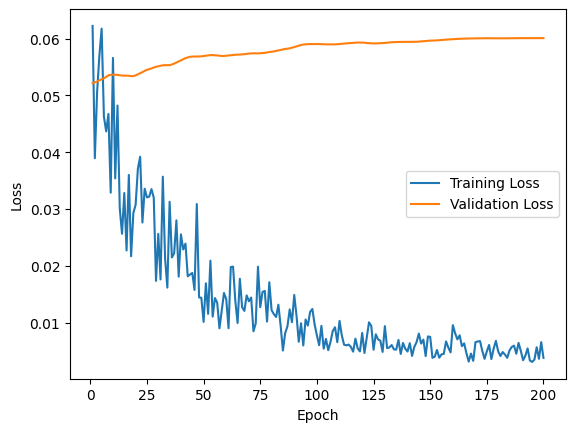

In [32]:
# Plot the loss values
epochs = range(1, epochs + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('epoch')

# Display the table
df_stats

,train_loss,valid_loss
epoch,,
1,0.062240,0.052173
2,0.038945,0.052306
3,0.050597,0.052434
4,0.056985,0.052650
5,0.061767,0.052854
...,...,...
196,0.003460,0.060090
197,0.005654,0.060091
198,0.003604,0.060091


import numpy as np
from google.colab import autoviz
df_265328170275662483 = autoviz.get_df('df_265328170275662483')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_265328170275662483, *['train_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_265328170275662483 = autoviz.get_df('df_265328170275662483')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_265328170275662483, *['valid_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_265328170275662483 = autoviz.get_df('df_265328170275662483')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_265328170275662483, *['train_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_265328170275662483 = autoviz.get_df('df_265328170275662483')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_265328170275662483, *['valid_loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_265328170275662483 = autoviz.get_df('df_265328170275662483')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_265328170275662483, *[[['train_loss', 'valid_loss']]], **{})
chart

In [ ]:
model.eval()

def predict_similarity(sentence_pair):
  test_input = tokenizer(sentence_pair, padding='max_length', max_length = 128, truncation=True, return_tensors="pt").to(device)
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']
  output = model(test_input)
  sim = torch.nn.functional.cosine_similarity(output[0], output[1], dim=0).item()

  return sim

In [ ]:
text1 = """
Gradient descent is an optimization algorithm which is commonly-used to train machine learning models and neural networks. Training data helps these models learn over time, and the cost function within gradient descent specifically acts as a barometer, gauging its accuracy with each iteration of parameter updates.
"""
text2 = """
Gradient descent (GD) is an iterative first-order optimisation algorithm used to find a local minimum/maximum of a given function. This method is commonly used in machine learning (ML) and deep learning(DL) to minimise a cost/loss function (e.g. in a linear regression). Due to its importance and ease of implementation, this algorithm is usually taught at the beginning of almost all machine learning courses.
"""
text3 = """
Artificial intelligence is the simulation of human intelligence processes by machines, especially computer systems. Specific applications of AI include expert systems, natural language processing, speech recognition and machine vision.
"""

text4 = """
Natural language processing (NLP) is a branch of artificial intelligence (AI) that enables computers to comprehend, generate, and manipulate human language. Natural language processing has the ability to interrogate the data with natural language text or voice.
"""

text5 = """
Gradient Descent is known as one of the most commonly used optimization algorithms to train machine learning models by means of minimizing errors between actual and expected results. Further, gradient descent is also used to train Neural Networks.

In mathematical terminology, Optimization algorithm refers to the task of minimizing/maximizing an objective function f(x) parameterized by x. Similarly, in machine learning, optimization is the task of minimizing the cost function parameterized by the model's parameters. The main objective of gradient descent is to minimize the convex function using iteration of parameter updates. Once these machine learning models are optimized, these models can be used as powerful tools for Artificial Intelligence and various computer science applications.
"""

# This is the summerized version of text5
text6 = """
 Gradient Descent is an optimization algorithm used to train machine learning models by minimizing errors between actual and expected results. It is also used to train Neural Networks and minimize the cost function parameterized by the model's parameters.
"""

text7 = """
The Fear Nothing Blood Test is able to give you an accurate understanding of your health by checking several key health indicators. The standard Fear Nothing Blood Test can tell you about your: Vitamin levels. Hormone levels. Liver health.
"""

text8 = """
This subject only gives a brief description about different types of materials used in building construction for members like foundation, masonry, arches, lintels, balcony, roof, floor, doors, windows, stairs, plastering, painting and other general topics. Properties of various construction materials, their uses and different applications are discussed in this subject.
"""

text9="""
Initial setting time for ideal cement mix is around 30 minutes for almost all kind of cements. For masonry cement it can be 90 minutes. Final setting time of ideal cement mix should be 10 hours at max. For masonry cement it shouldn’t exceed 24 hours.
"""

In [ ]:
example = [text1, text2]
print(f"Predicted similarity score: {round(predict_similarity(example), 2)}")

Predicted similarity score: 0.92


**Save Model**

In [8]:
PATH = 'bert-sts.pt'
torch.save(model.state_dict(), PATH)

NameError: ignored

In [ ]:
# In order to load the model
# First, you have to create an instance of the model's class
# And use the saving path for the loading
# Don't forget to set the model to the evaluation state using .eval()
model = BertForSTS()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
# calculte MAE for test set
test_ds = BDataset(test_df)
test_dataloader = DataLoader(
            test_ds,
            num_workers = 4,
            batch_size = batch_size # Use the same batch size
        )

model.eval()

criterion = CosineSimilarityLoss()
criterion = criterion.to(device)

total_test_loss = 0
nb_test_steps = 0

for test_data, test_label in tqdm(test_dataloader):
    
        test_data['input_ids'] = test_data['input_ids'].to(device)
        test_data['attention_mask'] = test_data['attention_mask'].to(device)
    
        test_data = collate_fn(test_data)
    
        with torch.no_grad():
            output = [model(feature) for feature in test_data]
    
        loss = criterion(output, test_label.to(device))
        total_test_loss += loss.item()

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

print("Test Loss: {0:.5f}".format(avg_test_loss))


In [ ]:
# Evaluate the model on the validation data
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [ ]:
# Load the fine-tuned model from the output_path
fine_tuned_model = SentenceTransformer('fine_tuned_model/')

In [ ]:
# Evaluate the model on the test data
# Define sentences1, sentences2, and scores for the evaluation
test_sentences1 = [example.texts[0] for example in test_examples]
test_sentences2 = [example.texts[1] for example in test_examples]
test_scores = [example.label for example in test_examples]

# Define the evaluation metric for test
evaluator_test = EmbeddingSimilarityEvaluator(test_sentences1, test_sentences2, test_scores)

# Evaluate the model on test data
test_score = evaluator_test(fine_tuned_model, output_path='fine_tuned_model/', epoch=5, steps=500)
print("Test score:", test_score)

In [ ]:
training_stats = []
training_stats.append(
          {
              'epoch': epoch_i + 1,
              'train_loss': avg_train_loss,
              'valid_loss': avg_val_loss,
          }
      )

train_loss = []
valid_loss = []

for i in range(len(training_stats)):
    train_loss.append(training_stats[i]['train_loss'])
    valid_loss.append(training_stats[i]['valid_loss'])

# Plot the loss values